In [188]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harlfoxem/housesalesprediction")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/housesalesprediction


In [321]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, RANSACRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')
sns.set()

In [190]:
os.listdir('/kaggle/input/housesalesprediction')

['kc_house_data.csv']

In [191]:
df = pd.read_csv('/kaggle/input/housesalesprediction/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [192]:
df.shape

(21613, 21)

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [194]:
df.apply(pd.isnull).sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [195]:
df.duplicated().sum()

0

In [196]:
def year_ext(text):
    return text[:4]

In [197]:
df['date_year'] = df['date'].apply(year_ext)

In [198]:
df['date_year'].value_counts()

date_year
2014    14633
2015     6980
Name: count, dtype: int64

In [199]:
def month_ext(text):
    return text[4: 6]

In [200]:
df['date_month'] = df['date'].apply(month_ext)

In [201]:
df['date_month'].value_counts()

date_month
05    2414
04    2231
07    2211
06    2180
08    1940
10    1878
03    1875
09    1774
12    1471
11    1411
02    1250
01     978
Name: count, dtype: int64

In [202]:
df['date_year'] = pd.to_numeric(df['date_year'])
df['date_month'] = pd.to_numeric(df['date_month'])

In [203]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date_year,date_month
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2


In [204]:
df.drop(columns = ['id'], axis = 1, inplace = True)

In [205]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date_year,date_month
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,...,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,...,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652,2014.322954,6.574423
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,...,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631,0.467616,3.115308
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,2014.000000,1.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,...,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000,2014.000000,4.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,...,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000,2014.000000,6.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,...,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,2015.000000,9.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,...,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,2015.000000,12.000000


In [206]:
df.drop(columns = ['zipcode'], axis = 1, inplace = True)

In [207]:
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'date_year', 'date_month'],
      dtype='object')

In [208]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,date_year,date_month
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,47.5112,-122.257,1340,5650,2014,10
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,47.7210,-122.319,1690,7639,2014,12
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,47.7379,-122.233,2720,8062,2015,2
3,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,47.5208,-122.393,1360,5000,2014,12
4,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,47.6168,-122.045,1800,7503,2015,2


In [209]:
cat_cols, num_cols = [], []
for column in df.columns:
    if df[column].nunique() < 20:
        cat_cols.append(column)
    else:
        num_cols.append(column)

In [210]:
print(f'*** Number of categorical columns: {len(cat_cols)}')
print(f'*** Categorical columns: {cat_cols}')
print(f'+++ Number of numerical columns: {len(num_cols)}')
print(f'+++ Numerical columns: {num_cols}')

*** Number of categorical columns: 8
*** Categorical columns: ['bedrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'date_year', 'date_month']
+++ Number of numerical columns: 13
+++ Numerical columns: ['date', 'price', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


bedrooms
Number of unique values: 13
Unique values: [ 3  2  4  5  1  6  7  0  8  9 11 10 33]
Value counts of unique values:
 bedrooms
3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
0       13
8       13
9        6
10       3
11       1
33       1
Name: count, dtype: int64


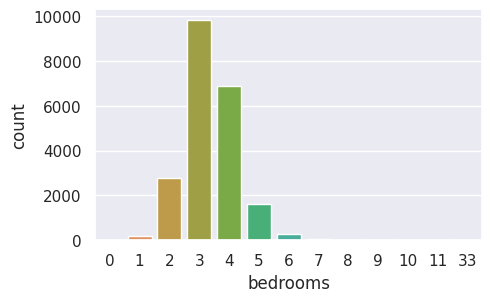

floors
Number of unique values: 6
Unique values: [1.  2.  1.5 3.  2.5 3.5]
Value counts of unique values:
 floors
1.0    10680
2.0     8241
1.5     1910
3.0      613
2.5      161
3.5        8
Name: count, dtype: int64


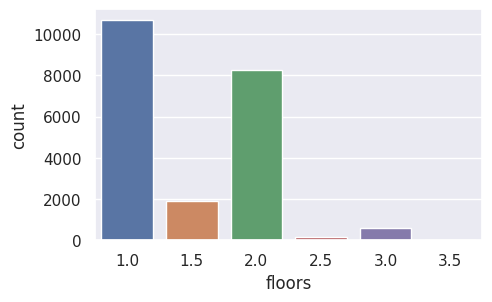

waterfront
Number of unique values: 2
Unique values: [0 1]
Value counts of unique values:
 waterfront
0    21450
1      163
Name: count, dtype: int64


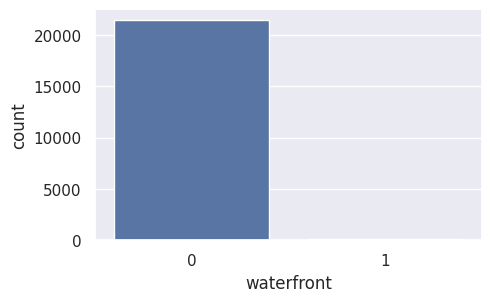

view
Number of unique values: 5
Unique values: [0 3 4 2 1]
Value counts of unique values:
 view
0    19489
2      963
3      510
1      332
4      319
Name: count, dtype: int64


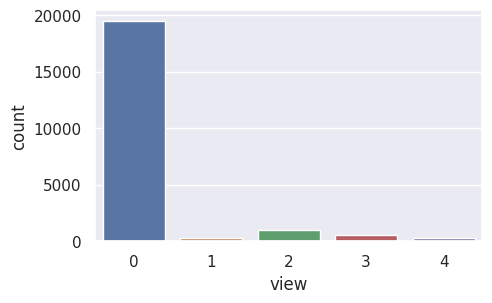

condition
Number of unique values: 5
Unique values: [3 5 4 1 2]
Value counts of unique values:
 condition
3    14031
4     5679
5     1701
2      172
1       30
Name: count, dtype: int64


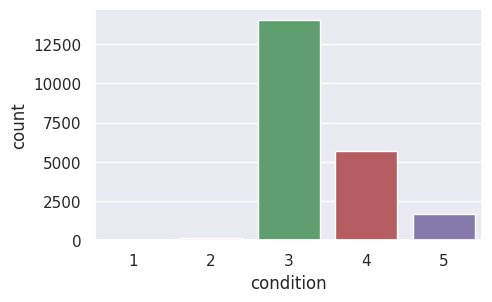

grade
Number of unique values: 12
Unique values: [ 7  6  8 11  9  5 10 12  4  3 13  1]
Value counts of unique values:
 grade
7     8981
8     6068
9     2615
6     2038
10    1134
11     399
5      242
12      90
4       29
13      13
3        3
1        1
Name: count, dtype: int64


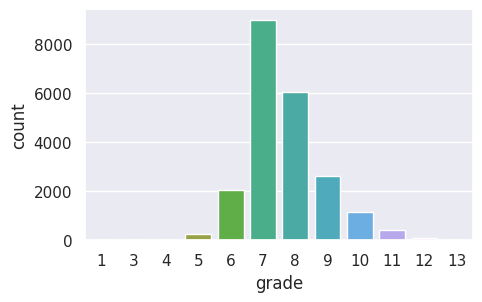

date_year
Number of unique values: 2
Unique values: [2014 2015]
Value counts of unique values:
 date_year
2014    14633
2015     6980
Name: count, dtype: int64


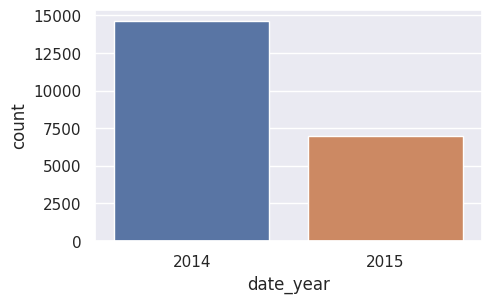

date_month
Number of unique values: 12
Unique values: [10 12  2  5  6  1  4  3  7  8 11  9]
Value counts of unique values:
 date_month
5     2414
4     2231
7     2211
6     2180
8     1940
10    1878
3     1875
9     1774
12    1471
11    1411
2     1250
1      978
Name: count, dtype: int64


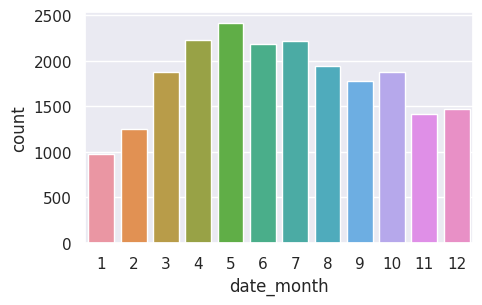

In [211]:
for column in cat_cols:
    print(f'{column}')
    print(f'Number of unique values: {df[column].nunique()}')
    print(f'Unique values: {df[column].unique()}')
    print(f'Value counts of unique values:\n {df[column].value_counts()}')
    plt.figure(figsize = (5, 3))
    sns.countplot(data = df, x = column)
    plt.show()
    plt.show('==============================================================')

In [212]:
df = df[df['bedrooms'] > 1.9]

In [213]:
df = df[df['bedrooms'] < 5.1]

In [214]:
df = df[df['floors'] < 2.4]

In [215]:
df.drop(columns = ['waterfront'], axis = 'columns', inplace = True)

In [216]:
df.drop(columns = ['view'], axis = 1, inplace = True)

In [217]:
df = df[df['condition'] > 2.1]

In [218]:
df = df[df['grade'] > 5.9]
df = df[df['grade'] < 10.1]

In [219]:
num_cols.remove('date')

In [220]:
df.shape

(19496, 19)

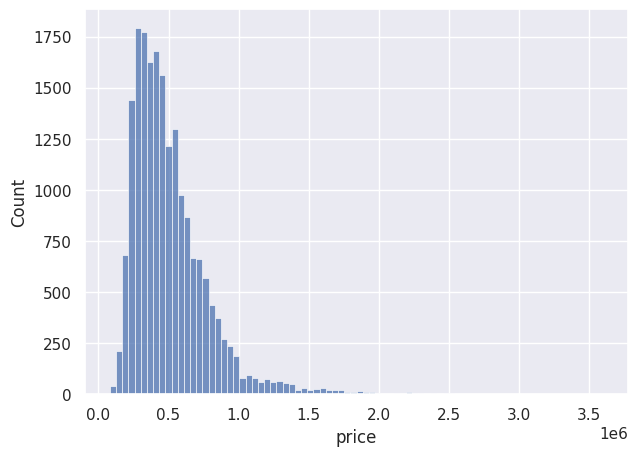

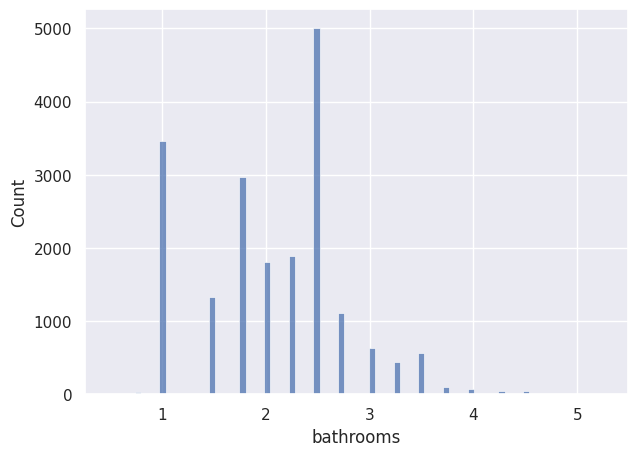

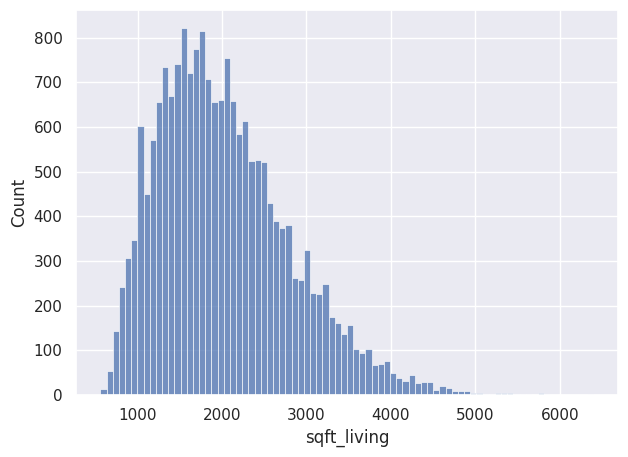

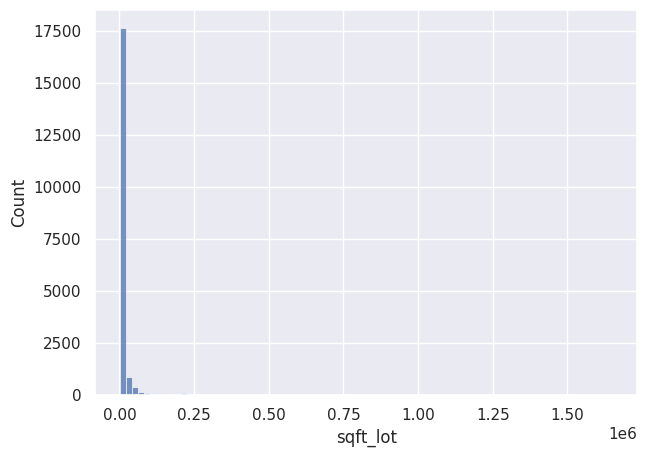

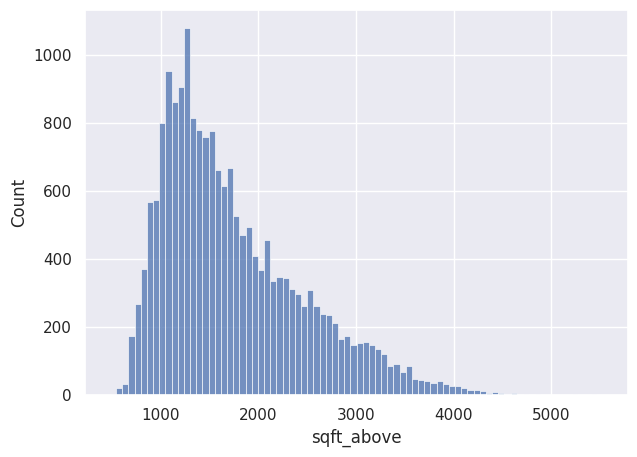

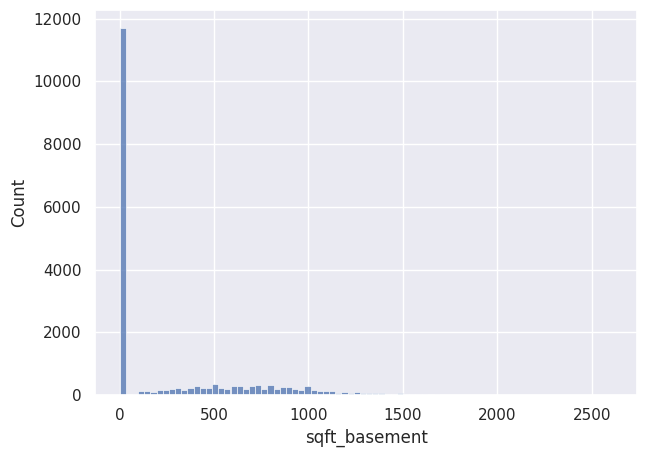

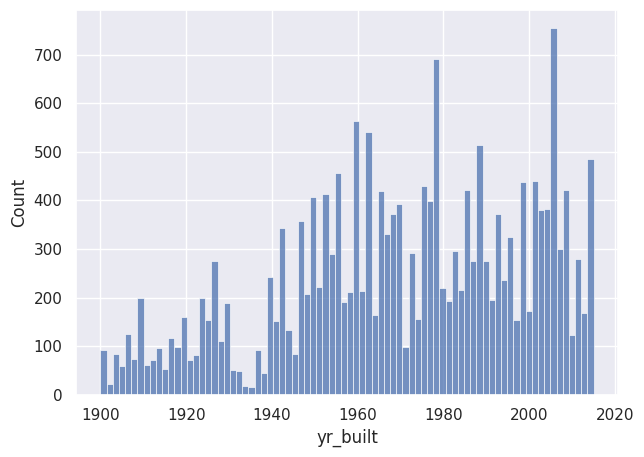

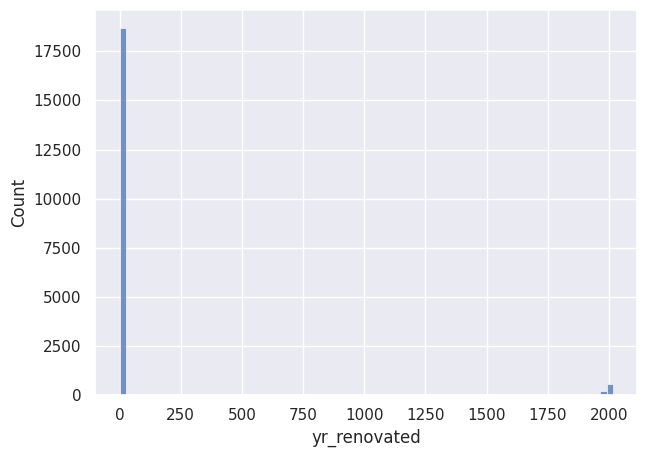

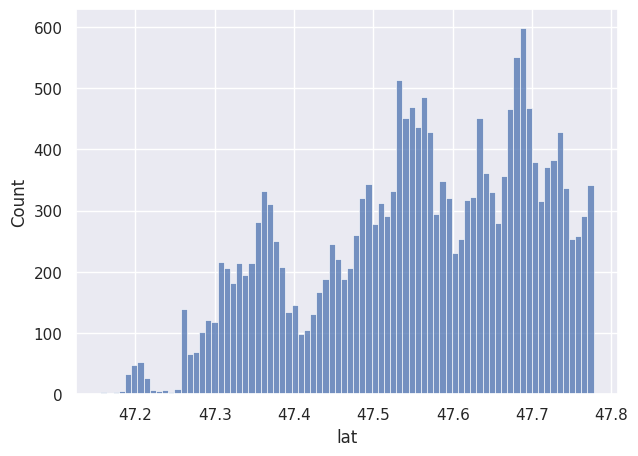

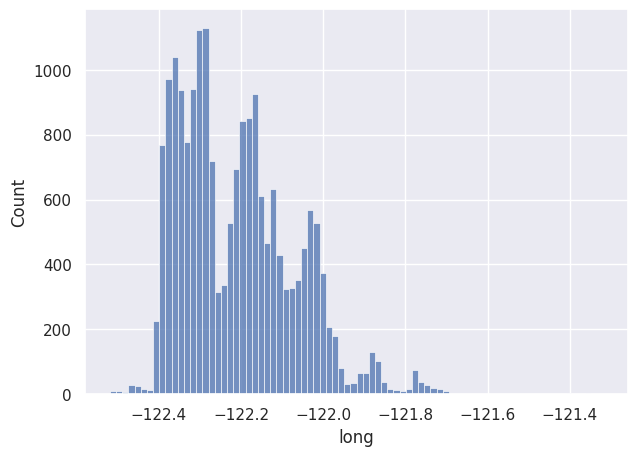

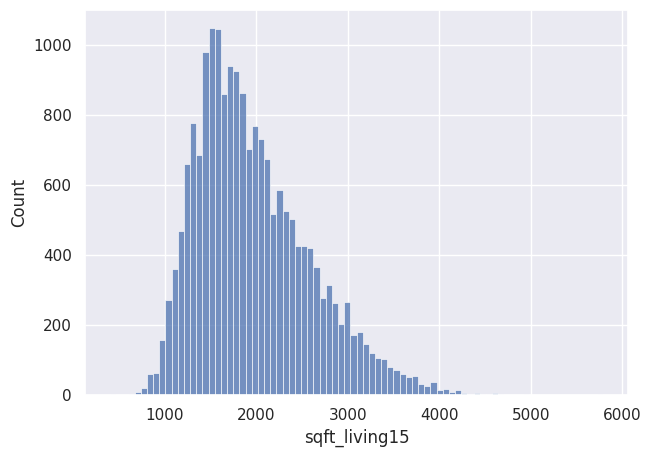

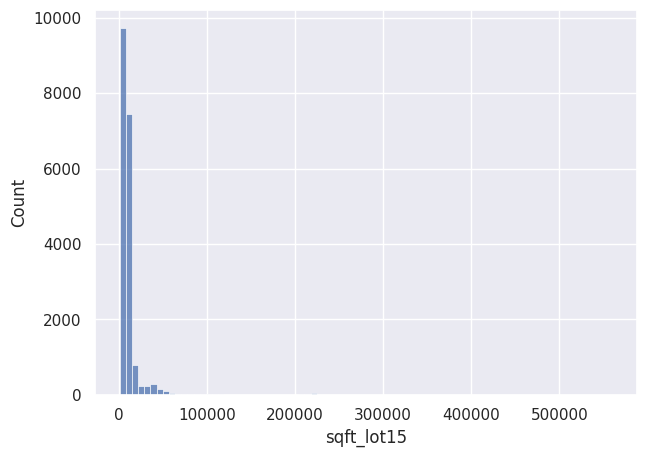

In [221]:
for column in num_cols:
    plt.figure(figsize = (7, 5))
    sns.histplot(data = df, x = column, bins = 80)
    plt.show()

In [222]:
df['bathrooms'].value_counts()

bathrooms
2.50    5012
1.00    3456
1.75    2965
2.25    1886
2.00    1806
1.50    1335
2.75    1105
3.00     626
3.50     565
3.25     443
3.75      96
4.00      72
4.25      42
4.50      38
0.75      29
1.25       6
5.00       5
4.75       5
0.50       2
5.25       2
Name: count, dtype: int64

In [223]:
df = df[df['bathrooms'] <= 3.25]
df = df[df['bathrooms'] != 0.75]
df = df[df['bathrooms'] != 1.25]
df = df[df['bathrooms'] != 0.5]

In [224]:
df.shape

(18634, 19)

In [225]:
df['sqft_lot'].nunique()

8593

In [226]:
df['yr_renovated'].nunique()

69

In [227]:
num_cols.remove('bathrooms')

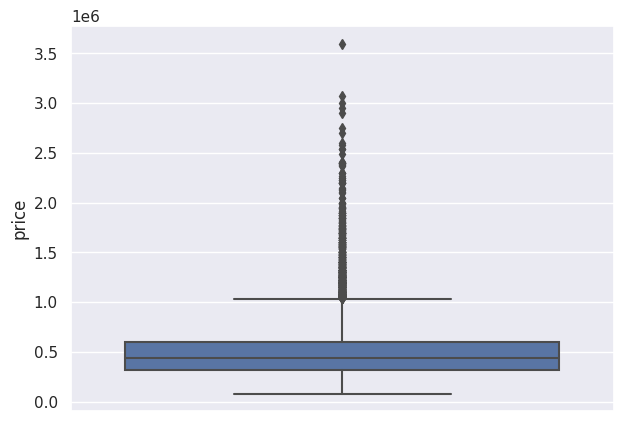

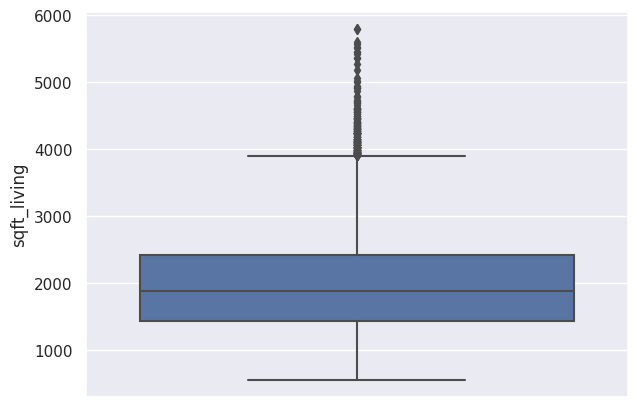

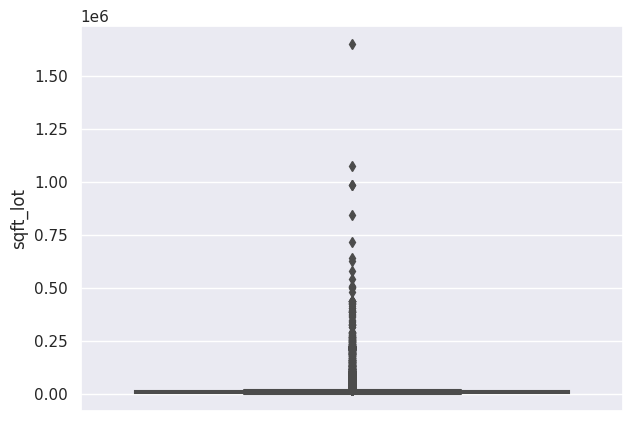

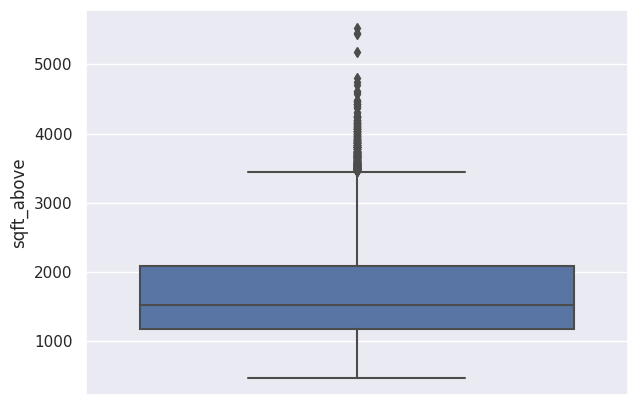

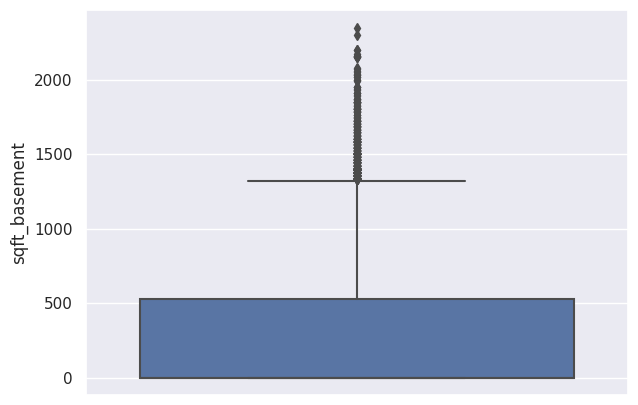

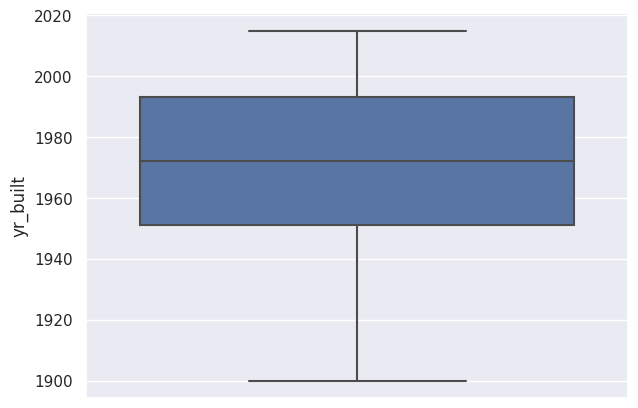

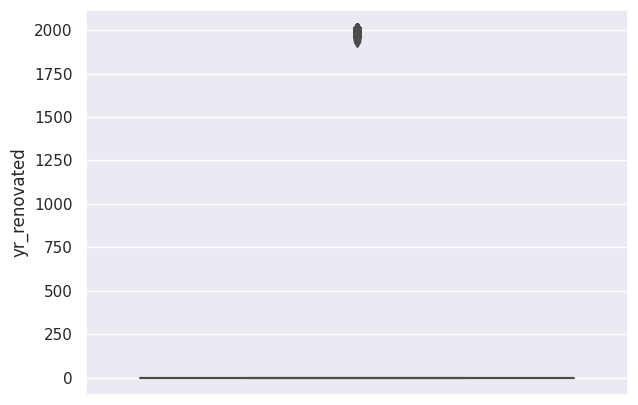

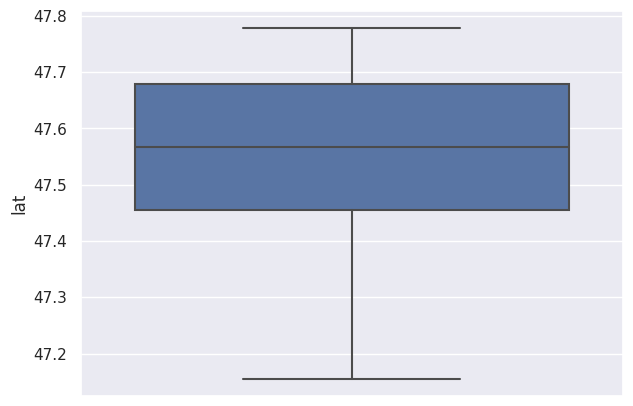

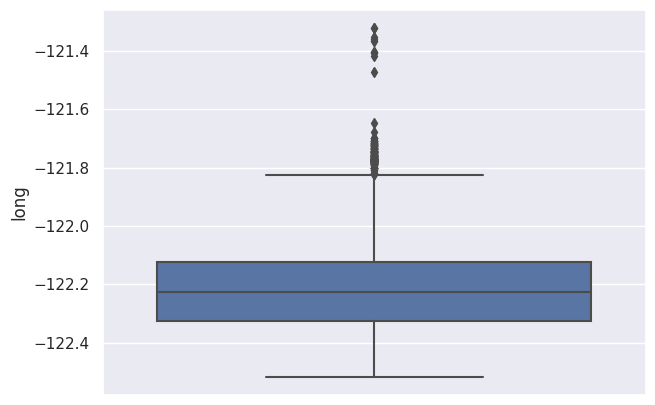

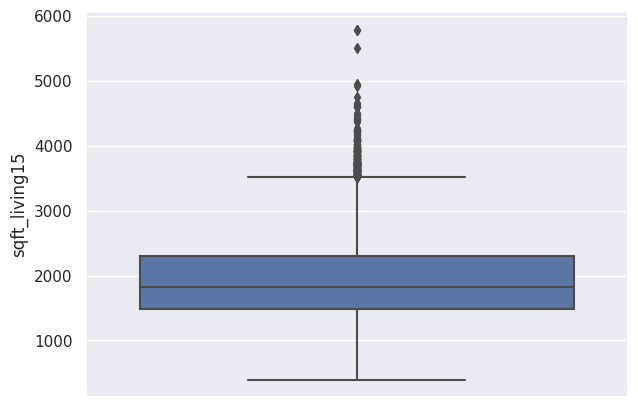

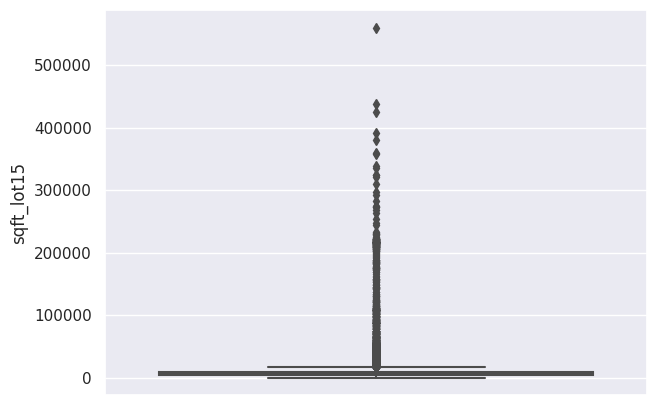

In [228]:
for column in num_cols:
    plt.figure(figsize = (7, 5))
    sns.boxplot(data = df, y = column)
    plt.show()

<Axes: xlabel='sqft_lot', ylabel='Count'>

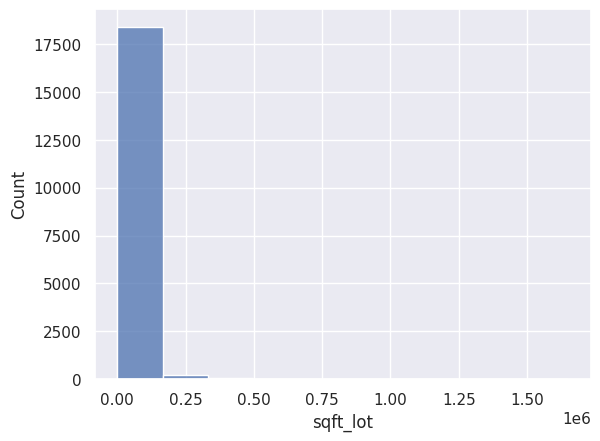

In [229]:
sns.histplot(data = df, x = 'sqft_lot', bins = 10)

In [230]:
df[df['sqft_lot'] > 15000].shape

(2557, 19)

In [231]:
df = df[df['sqft_lot'] < 15000]

<Axes: xlabel='sqft_lot', ylabel='Count'>

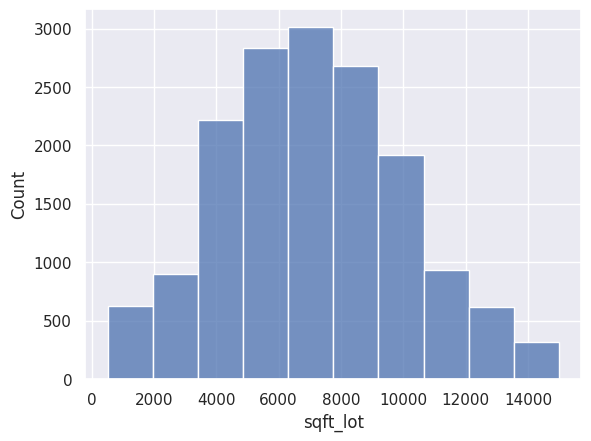

In [232]:
sns.histplot(data = df, x = 'sqft_lot', bins = 10)

In [233]:
df[df['sqft_living'] > 3800].shape

(143, 19)

In [234]:
df = df[df['sqft_living'] < 3800]

In [235]:
df[df['sqft_basement'] > 1250].shape

(315, 19)

In [236]:
df = df[df['sqft_basement'] < 1250]

<Axes: xlabel='yr_renovated', ylabel='Count'>

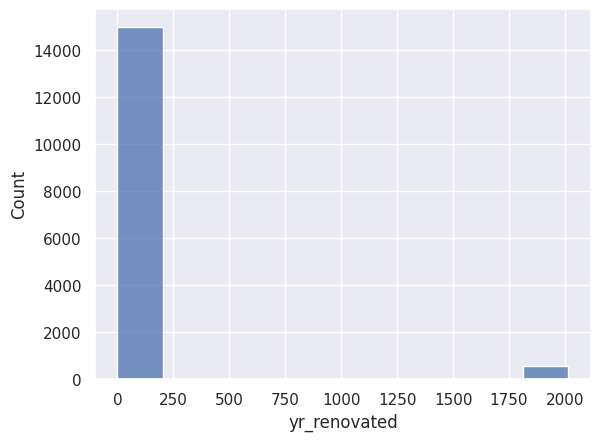

In [237]:
sns.histplot(data = df, x = 'yr_renovated', bins = 10)

In [238]:
df[df['yr_renovated'] > 250].shape

(569, 19)

In [239]:
df = df[df['yr_renovated'] < 250]

<Axes: xlabel='yr_renovated', ylabel='Count'>

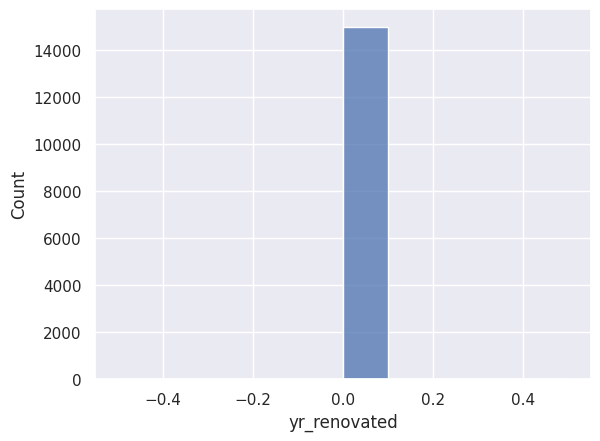

In [240]:
sns.histplot(data = df, x = 'yr_renovated', bins = 10)

In [241]:
df[df['yr_renovated'] < 0].shape

(0, 19)

<Axes: ylabel='yr_renovated'>

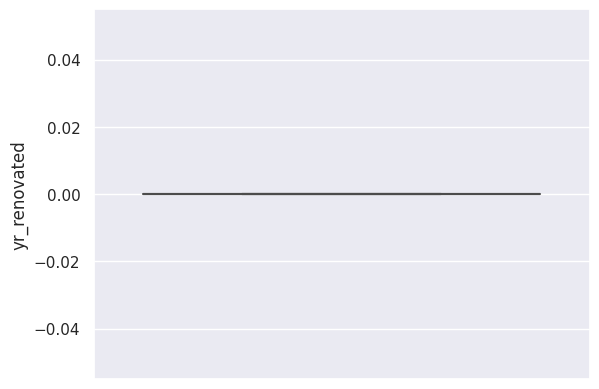

In [242]:
sns.boxplot(data = df, y = 'yr_renovated')

In [243]:
df['yr_renovated'].value_counts()

yr_renovated
0    14987
Name: count, dtype: int64

In [244]:
df.drop(columns = 'yr_renovated', axis = 1, inplace = True)

In [245]:
df[df['long'] > -121.9].shape

(363, 18)

In [246]:
df = df[df['long'] < -121.9]

In [247]:
df[df['sqft_living15'] > 3500].shape

(87, 18)

In [248]:
df = df[df['sqft_living15'] < 3500]

<Axes: xlabel='sqft_lot15', ylabel='Count'>

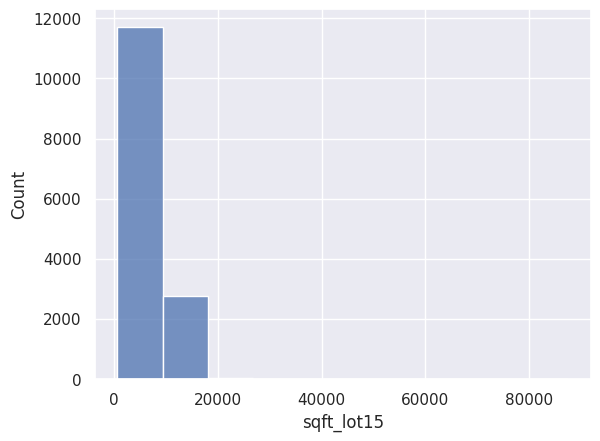

In [249]:
sns.histplot(data = df, x = 'sqft_lot15', bins = 10)

In [250]:
df[df['sqft_lot15'] > 18000].shape

(57, 18)

In [251]:
df = df[df['sqft_lot15'] < 18000]

<Axes: xlabel='sqft_lot15', ylabel='Count'>

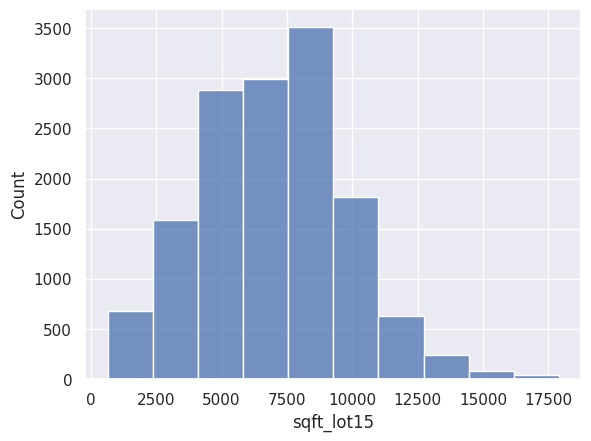

In [252]:
sns.histplot(data = df, x = 'sqft_lot15', bins = 10)

In [253]:
df[df['sqft_lot15'] > 12500].shape

(411, 18)

In [254]:
df.shape

(14472, 18)

In [255]:
df = df[df['sqft_lot15'] < 12500]

<Axes: xlabel='sqft_lot15', ylabel='Count'>

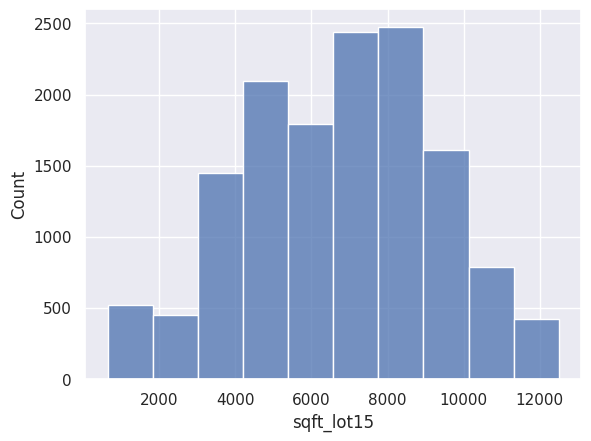

In [256]:
sns.histplot(data = df, x = 'sqft_lot15', bins = 10)

<Axes: ylabel='price'>

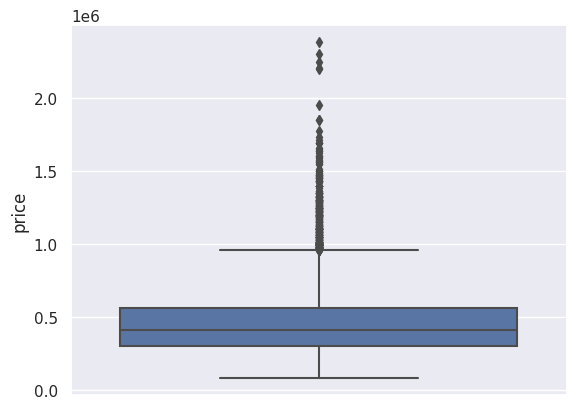

In [257]:
sns.boxplot(data = df, y = 'price')

<Axes: xlabel='price', ylabel='Count'>

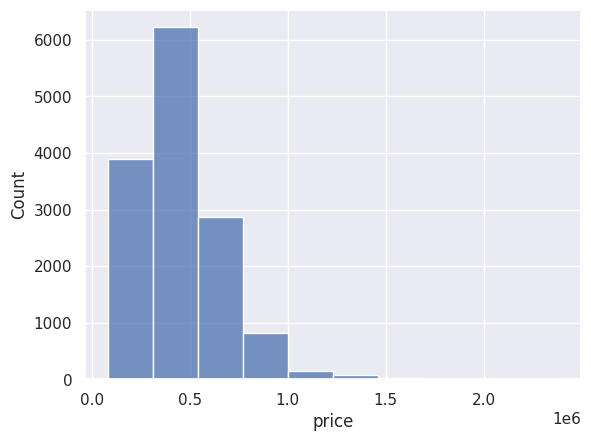

In [258]:
sns.histplot(data = df, x = 'price', bins = 10)

In [259]:
df[df['price'] > 900000].shape

(468, 18)

In [260]:
df = df[df['price'] < 900000]

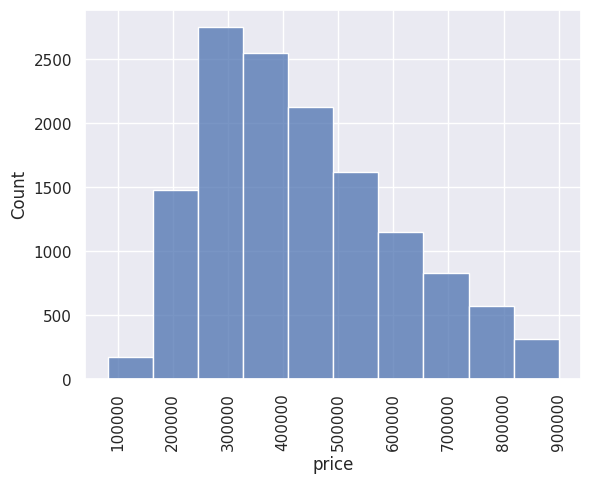

In [261]:
sns.histplot(data = df, x = 'price', bins = 10)
plt.xticks(rotation = 90)
plt.show()

<Axes: ylabel='price'>

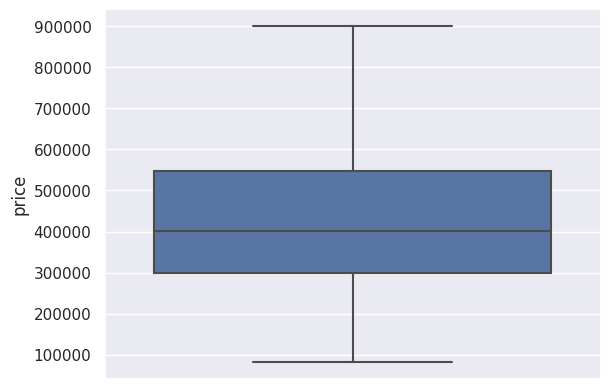

In [262]:
sns.boxplot(data = df, y = 'price')

In [263]:
df.shape

(13572, 18)

In [264]:
df['date_year'].value_counts()

date_year
2014    9137
2015    4435
Name: count, dtype: int64

In [265]:
df_2014 = df[df['date_year'] == 2014]
df_2015 = df[df['date_year'] == 2015]

In [266]:
df_2015.shape

(4435, 18)

In [267]:
df_2015[df_2015['date_month'] >= 3].shape

(3026, 18)

In [268]:
df_train = df_2014
df_valid = df_2015[df_2015['date_month'] < 3]
df_test = df_2015[df_2015['date_month'] >= 3]

In [269]:
print(f'Train set size: {df_train.shape[0]}')
print(f'Validation set size: {df_valid.shape[0]}')
print(f'Test set size: {df_test.shape[0]}')

Train set size: 9137
Validation set size: 1409
Test set size: 3026


In [270]:
df_train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,date_year,date_month
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,3,7,1180,0,1955,47.5112,-122.257,1340,5650,2014,10
3,20141209T000000,604000.0,4,3.00,1960,5000,1.0,5,7,1050,910,1965,47.5208,-122.393,1360,5000,2014,12
6,20140627T000000,257500.0,3,2.25,1715,6819,2.0,3,7,1715,0,1995,47.3097,-122.327,2238,6819,2014,6
11,20140527T000000,468000.0,2,1.00,1160,6000,1.0,4,7,860,300,1942,47.6900,-122.292,1330,6000,2014,5
13,20141007T000000,400000.0,3,1.75,1370,9680,1.0,4,7,1370,0,1977,47.6127,-122.045,1370,10208,2014,10


In [271]:
df_train.drop(columns = ['date', 'date_year', 'date_month'], axis = 1, inplace = True)
df_test.drop(columns = ['date', 'date_year', 'date_month'], axis = 1, inplace = True)
df_valid.drop(columns = ['date', 'date_year', 'date_month'], axis = 1, inplace = True)

In [272]:
df_train.shape

(9137, 15)

In [273]:
df_train.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'lat',
       'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [274]:
df_train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,0,1955,47.5112,-122.257,1340,5650
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,910,1965,47.5208,-122.393,1360,5000
6,257500.0,3,2.25,1715,6819,2.0,3,7,1715,0,1995,47.3097,-122.327,2238,6819
11,468000.0,2,1.00,1160,6000,1.0,4,7,860,300,1942,47.6900,-122.292,1330,6000
13,400000.0,3,1.75,1370,9680,1.0,4,7,1370,0,1977,47.6127,-122.045,1370,10208


In [275]:
df_train.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15
count,9137.000000,9137.000000,9137.000000,9137.000000,9137.000000,9137.000000,9137.000000,9137.000000,9137.000000,9137.000000,9137.000000,9137.000000,9137.000000,9137.000000,9137.000000
mean,432027.952172,3.256430,1.938711,1805.701105,6857.900843,1.408996,3.466346,7.380541,1570.699901,235.001204,1969.446317,47.558369,-122.236005,1804.102769,6781.901937
std,170574.518140,0.770955,0.618436,598.741830,2787.236170,0.466486,0.659690,0.839055,605.142209,347.249634,29.092002,0.142511,0.116861,507.489252,2514.251182
min,82000.000000,2.000000,1.000000,560.000000,520.000000,1.000000,3.000000,6.000000,480.000000,0.000000,1900.000000,47.189500,-122.475000,620.000000,651.000000
25%,299000.000000,3.000000,1.500000,1350.000000,4871.000000,1.000000,3.000000,7.000000,1120.000000,0.000000,1950.000000,47.456800,-122.335000,1430.000000,4980.000000
50%,402000.000000,3.000000,2.000000,1750.000000,7064.000000,1.000000,3.000000,7.000000,1410.000000,0.000000,1969.000000,47.569800,-122.267000,1720.000000,7191.000000
75%,545000.000000,4.000000,2.500000,2198.000000,8712.000000,2.000000,4.000000,8.000000,1890.000000,480.000000,1994.000000,47.683700,-122.157000,2110.000000,8509.000000
max,899900.000000,5.000000,3.250000,3760.000000,14952.000000,2.000000,5.000000,10.000000,3730.000000,1240.000000,2015.000000,47.777600,-121.902000,3494.000000,12497.000000


In [276]:
def data_label(data):
    X_data = data.drop(columns = ['price'], axis = 1)
    y_label = data['price']
    return X_data, y_label

In [277]:
X_train, y_train = data_label(df_train)
X_test, y_test = data_label(df_test)
X_valid, y_valid = data_label(df_valid)

In [278]:
X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,3,7,1180,0,1955,47.5112,-122.257,1340,5650
3,4,3.00,1960,5000,1.0,5,7,1050,910,1965,47.5208,-122.393,1360,5000
6,3,2.25,1715,6819,2.0,3,7,1715,0,1995,47.3097,-122.327,2238,6819
11,2,1.00,1160,6000,1.0,4,7,860,300,1942,47.6900,-122.292,1330,6000
13,3,1.75,1370,9680,1.0,4,7,1370,0,1977,47.6127,-122.045,1370,10208


In [279]:
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
X_valid.reset_index(drop = True, inplace = True)

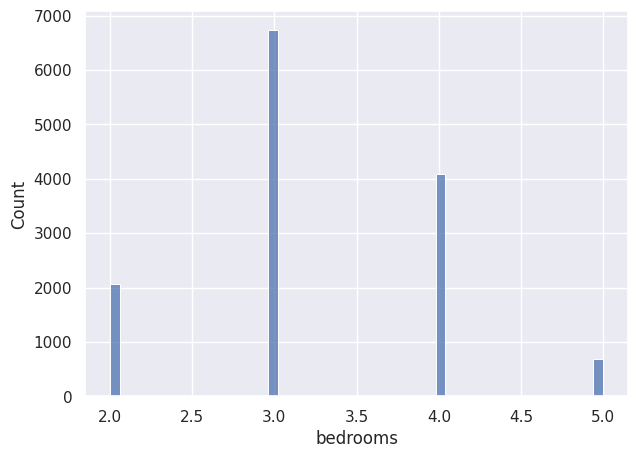

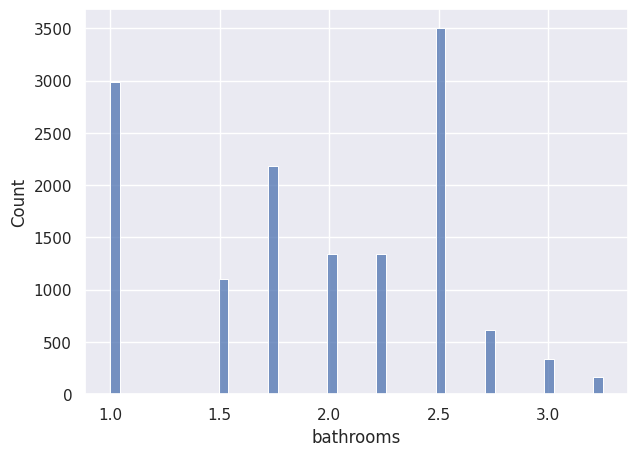

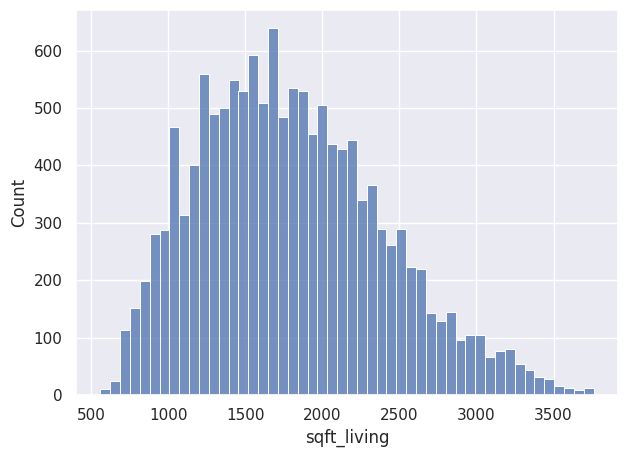

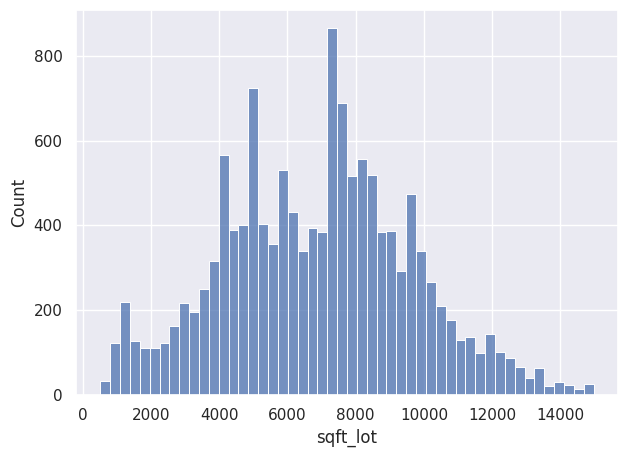

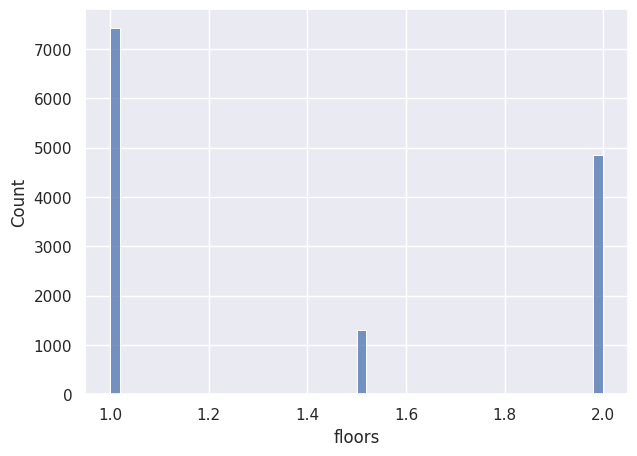

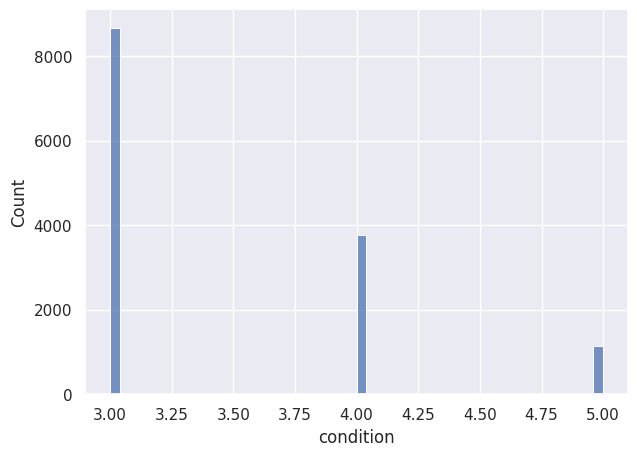

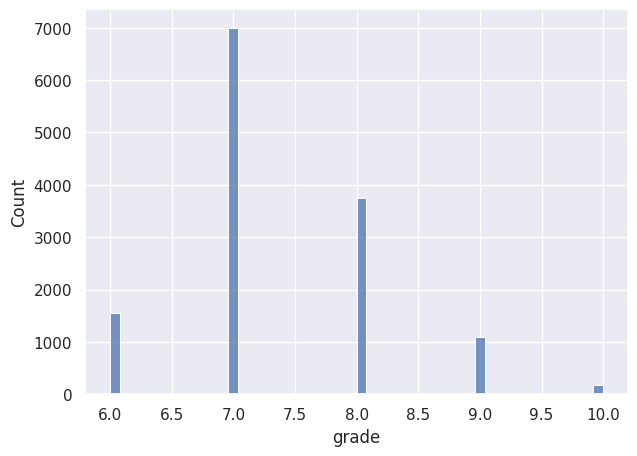

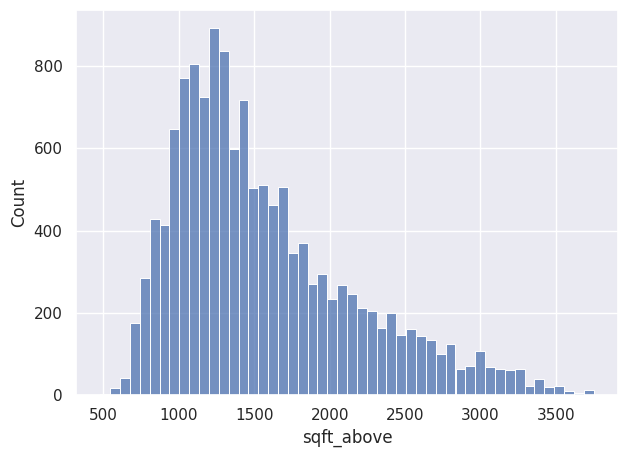

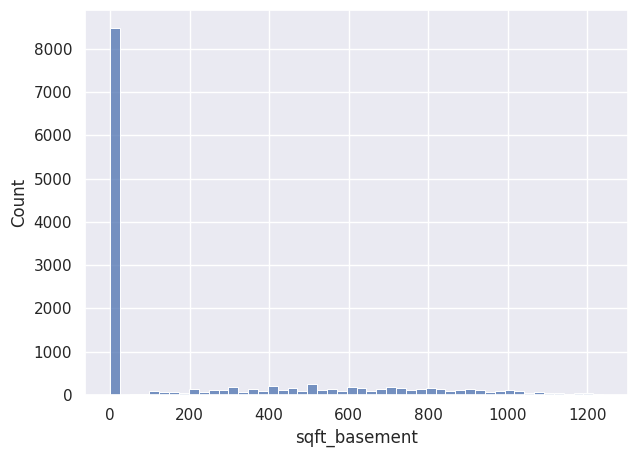

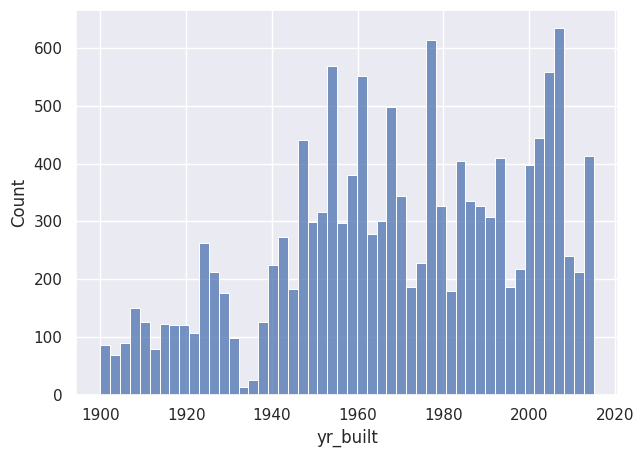

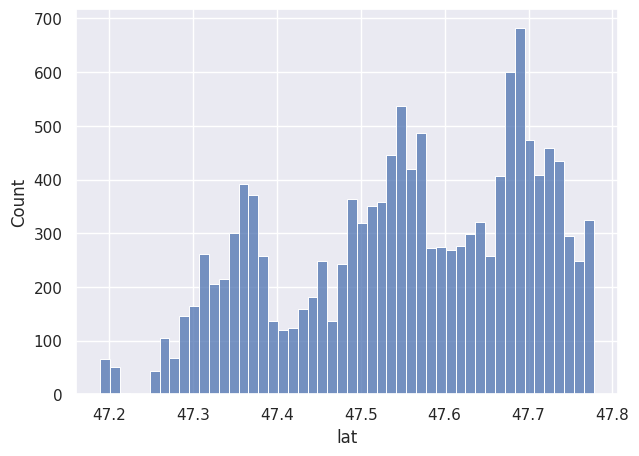

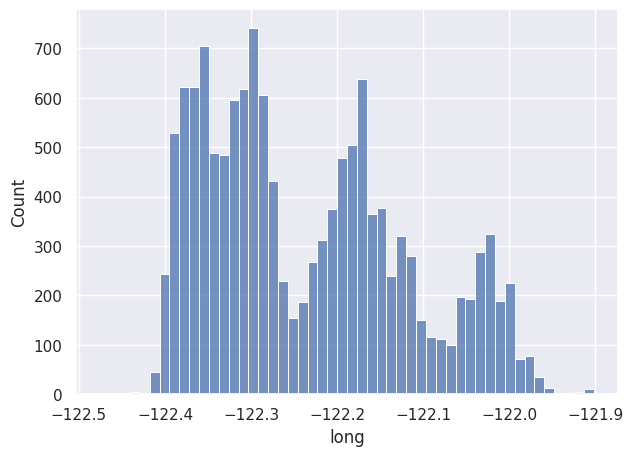

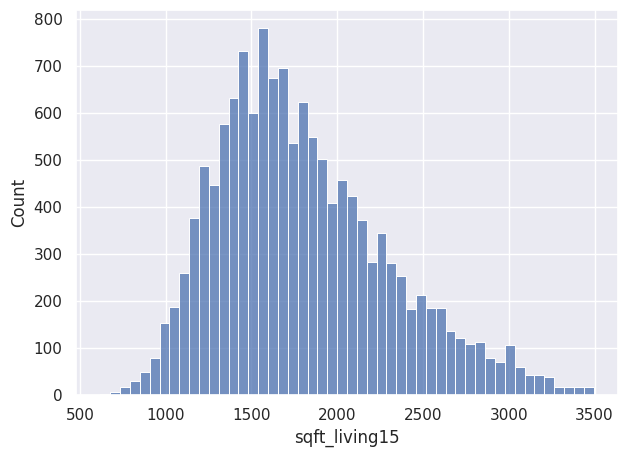

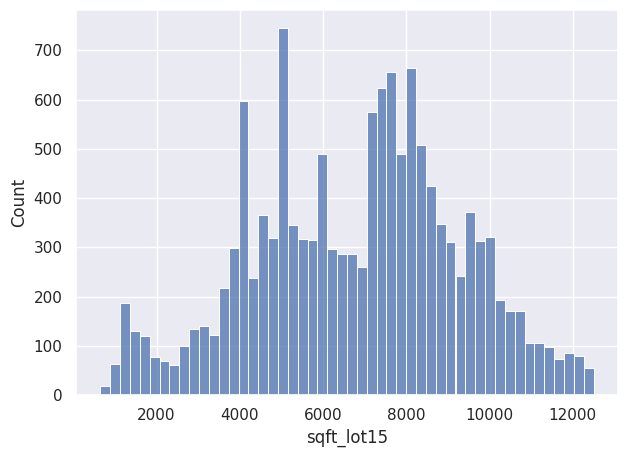

In [280]:
for column in X_train.columns:
    plt.figure(figsize = (7, 5))
    sns.histplot(data = df, x = column, bins = 50)
    plt.show()

In [281]:
pipeline1 = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

In [282]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 101)

In [283]:
scores = cross_val_score(pipeline1, X_train, y_train, cv = skf)

In [284]:
print(f'Validation score of Linear Regression: {scores.mean():.3f}')

Validation score of Linear Regression: 0.685


In [285]:
pipeline2 = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV(alphas = (1.0, 0.1, 0.005, 0.0025, 0.001, 0.00025)))
])

In [286]:
scores2 = cross_val_score(pipeline2, X_train, y_train, cv = skf)

In [287]:
print(f'Validation score of Ridge Regression: {scores2.mean():.3f}')

Validation score of Ridge Regression: 0.685


In [288]:
pipeline3 = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(alphas = (1.0, 0.1, 0.005, 0.0025, 0.001, 0.00025)))
])

In [289]:
scores3 = cross_val_score(pipeline3, X_train, y_train, cv = skf)

In [290]:
print(f'Validation score of Lasso Regression: {scores3.mean():.3f}')

Validation score of Lasso Regression: 0.685


In [291]:
lr = LinearRegression()

In [292]:
pipeline4 = Pipeline([
    ('scaler', StandardScaler()),
    ('RANSACRegressor', RANSACRegressor(lr))
])

In [293]:
scores4 = cross_val_score(pipeline4, X_train, y_train, cv = skf)

In [294]:
print(f'Validation score of RANSACRegressor: {scores4.mean():.3f}')

Validation score of RANSACRegressor: 0.564


In [295]:
poly = PolynomialFeatures(degree = 2)

In [296]:
X_train_poly = poly.fit_transform(X_train)

In [297]:
X_train_poly.shape

(9137, 120)

In [298]:
X_train.shape

(9137, 14)

In [299]:
pipeline5 = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

In [300]:
scores5 = cross_val_score(pipeline5, X_train_poly, y_train, cv = skf)

In [301]:
print(f'Validation score of Polynomial Regression (degree = 2): {scores5.mean():.3f}')

Validation score of Polynomial Regression (degree = 2): 0.745


In [302]:
print(f'Validation score of Linear Regression: {scores.mean():.3f}')

Validation score of Linear Regression: 0.685


In [303]:
pipeline6 = Pipeline([
    ('poly', PolynomialFeatures(degree = 3)),
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

In [304]:
scores6 = cross_val_score(pipeline6, X_train, y_train, cv = skf)

In [305]:
print(f'Validation score of Polynomial Regression (degree = 3): {scores6.mean():.3f}')

Validation score of Polynomial Regression (degree = 3): 0.809


In [306]:
pipeline7 = Pipeline([
    ('poly', PolynomialFeatures(degree = 4)),
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

In [307]:
scores7 = cross_val_score(pipeline7, X_train, y_train, cv = skf)

In [308]:
print(f'Validation score of Polynomial Regression (degree = 4): {scores7.mean():.3f}')

Validation score of Polynomial Regression (degree = 4): 0.583


In [309]:
poly2 = PolynomialFeatures(degree = 3)

In [310]:
X_train_poly2 = poly2.fit_transform(X_train)

In [311]:
X_train_poly2.shape

(9137, 680)

In [312]:
pipeline9 = Pipeline([
    ('poly', PolynomialFeatures(degree = 3)),
    ('fsn', SelectFromModel(lr, threshold = 90)),
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

In [313]:
scores9 = cross_val_score(pipeline9, X_train, y_train, cv = skf)

In [314]:
print(f'Validation score of Polynomial Regression (degree = 3) with feature selection: {scores9.mean():.3f}')

Validation score of Polynomial Regression (degree = 3) with feature selection: 0.815


In [315]:
print(f'Validation score of Polynomial Regression (degree = 3): {scores6.mean():.3f}')

Validation score of Polynomial Regression (degree = 3): 0.809


In [317]:
pipeline9.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('fsn',
                 SelectFromModel(estimator=LinearRegression(), threshold=90)),
                ('scaler', StandardScaler()), ('lr', LinearRegression())])

In [319]:
pipeline9.score(X_test, y_test)

0.7579819966079087

In [320]:
y_pred = pipeline9.predict(X_test)

In [322]:
print(f'Mean squared error: {mean_squared_error(y_test, y_pred):.3f}')
print(f'Mean absolute error: {mean_absolute_error(y_test, y_pred):.3f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')

Mean squared error: 7109238270.369
Mean absolute error: 62920.097
RMSE: 84316.299


In [323]:
y_pred

array([334823.84450739, 303679.80974234, 621660.30473098, ...,
       484033.73211464, 499990.83288212, 512762.6950764 ])

In [325]:
y_test

8        229500.0
9        323000.0
14       530000.0
19       230000.0
29       719000.0
           ...   
21541    402723.0
21544    589999.0
21557    530000.0
21562    422000.0
21566    710200.0
Name: price, Length: 3026, dtype: float64

In [324]:
y_train.mean()

432027.9521724855

In [326]:
y_train.reset_index(drop = True, inplace = True)

In [327]:
y_test.reset_index(drop = True, inplace = True)
y_valid.reset_index(drop = True, inplace = True)

In [331]:
poly3 = PolynomialFeatures(degree = 3)

In [332]:
X_train_p = poly3.fit_transform(X_train)
X_test_p = poly3.transform(X_test)
X_valid_p = poly3.transform(X_valid)

In [333]:
sfm = SelectFromModel(lr, threshold = 90)

In [335]:
X_train_f = sfm.fit_transform(X_train_p, y_train)
X_test_f = sfm.transform(X_test_p)
X_valid_f = sfm.transform(X_valid_p)

In [337]:
X_train_f.shape

(9137, 314)

In [338]:
scaler = StandardScaler()

In [339]:
X_train_scaled = scaler.fit_transform(X_train_f)
X_test_scaled = scaler.transform(X_test_f)
X_valid_scaled = scaler.transform(X_valid_f)

In [355]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import trange
import torch.optim as optim

In [357]:
class MyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y

In [358]:
train_dataset = MyDataset(X_train_scaled, y_train)
test_dataset = MyDataset(X_test_scaled, y_test)
valid_dataset = MyDataset(X_valid_scaled, y_valid)

In [444]:
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False)
valid_loader = DataLoader(valid_dataset, batch_size = 128, shuffle = False)

In [445]:
device = ('cuda' if torch.cuda.is_available()
         else 'mps' if torch.backends.mps.is_available()
         else 'cpu')

In [446]:
print(f'Using {device} device')

Using cpu device


In [447]:
def plot_results(train_losses, valid_losses):
    plt.figure(figsize = (7, 5))
    plt.plot(train_losses, label = 'Train', color = 'teal')
    plt.plot(valid_losses, label = 'Validation', color = 'orange')
    plt.title('Train losses vs Validation losses', fontsize = 15)
    plt.xlabel('Epoch', fontsize = 10)
    plt.ylabel('Loss (mse)', fontsize = 10)
    plt.legend()
    plt.show()

In [448]:
def train_step(model, criterion, optimizer, dataloader, device = device):
    running_loss = 0.0
    model.train()
    for x, y in dataloader:
        x, y = x.to(device).float(), y.to(device).float()
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

In [449]:
def valid_step(model, criterion, dataloader, device = device):
    running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device).float(), y.to(device).float()
            pred = model(x)
            running_loss += criterion(pred, y).item()
    return running_loss / len(dataloader)

In [450]:
def train_model(model, n_epochs, optimizer, train_loader, valid_loader, device = device):
    train_losses, valid_losses = [], []
    criterion = nn.MSELoss()
    for epoch in (pbar := trange(n_epochs)):
        train_loss = train_step(model, criterion, optimizer, train_loader, device)
        valid_loss = valid_step(model, criterion, valid_loader, device)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        pbar.set_description(f'Train Loss: {train_loss:.3f} | Validation Loss: {valid_loss:.3f}')
    plot_results(train_losses, valid_losses)
    return {'train_loss': train_loss, 'valid_loss': valid_loss}

In [451]:
class nn_model(nn.Module):
    def __init__(self, input_size):
        super(nn_model, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.10),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)

Train Loss: 33948726613.333 | Validation Loss: 26409822634.667: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


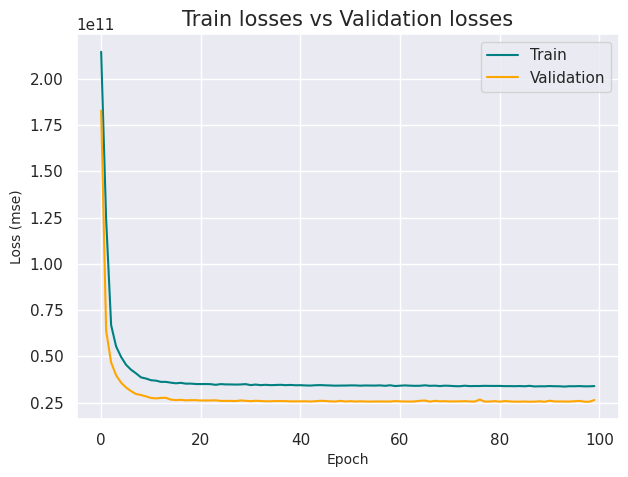

In [452]:
model = nn_model(314).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 100, optimizer, train_loader, valid_loader)

In [453]:
X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,3,7,1180,0,1955,47.5112,-122.257,1340,5650
1,4,3.00,1960,5000,1.0,5,7,1050,910,1965,47.5208,-122.393,1360,5000
2,3,2.25,1715,6819,2.0,3,7,1715,0,1995,47.3097,-122.327,2238,6819
3,2,1.00,1160,6000,1.0,4,7,860,300,1942,47.6900,-122.292,1330,6000
4,3,1.75,1370,9680,1.0,4,7,1370,0,1977,47.6127,-122.045,1370,10208


In [459]:
X_train.shape

(9137, 14)

In [455]:
X_train_scaled2 = scaler.fit_transform(X_train)
X_test_scaled2 = scaler.transform(X_test)
X_valid_scaled2 = scaler.transform(X_valid)

In [457]:
train_dataset2 = MyDataset(X_train_scaled2, y_train)
test_dataset2 = MyDataset(X_test_scaled2, y_test)
valid_dataset2 = MyDataset(X_valid_scaled2, y_valid)

In [458]:
train_loader2 = DataLoader(train_dataset2, batch_size = 128, shuffle = True)
test_loader2 = DataLoader(test_dataset2, batch_size = 128, shuffle = False)
valid_loader2 = DataLoader(valid_dataset2, batch_size = 128, shuffle = False)

Train Loss: 32711490929.778 | Validation Loss: 25574603093.333: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


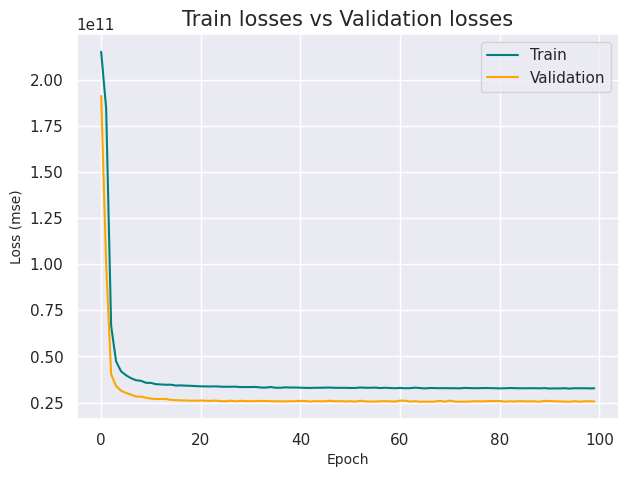

In [461]:
model2 = nn_model(14).to(device)
optimizer = optim.Adam(model2.parameters(), lr = 0.001)
results = train_model(model2, 100, optimizer, train_loader2, valid_loader2)

In [466]:
y_train.mean()

432027.9521724855